# Train classifiers on BirdNET or Perch embeddings

This notebook shows examples of how to train simple one-layer or multi-layer fully-connected neural networks (aka multi-layer perceptron networks, MLPs) on Perch [1] and BirdNET [2], which are TensorFlow models. For a more general introduction to transfer learning tools in OpenSoundscape see the `transfer_learning.ipynb` notebook, which focuses on PyTorch (rather than Tensorflow) embedding models. 

Though BirdNET and Perch are TensorFlow models, we can still use them as feature extractors (to generate embeddings) and train shallow classifiers on top of them with PyTorch. We just won't be able to train the feature extractor weights at all. 

For this notebook, you'll need a Python environment with `tensorflow` and `tensorflow-hub` packages installed. If you want cuda gpu acceleration on a linux machine, check this [table](https://www.tensorflow.org/install/source#gpu) for the `tensorflow` and `cudnn` package versions you'll need to be compatible with your current CUDA version (you can check the cuda version on your machine by calling `nvidia-smi` from command line). Note that the `cudnn` package version might conflict with which version PyTorch wants, so we recommend creating separate Python environments for pytorch and tensorflow cuda-compatability. 

Note that in this tutorial, all classifiers are trained as multi-target (each class is predicted independently, such that any sample can have 0, 1, or >1 classes present). Most bioacoustics classification tasks are multi-target. 


> Note on Error "module not found: bioacoustics_model_zoo" when using multiprocessing (num_workers>0):
if you get an error to this effect, please install the bioacoustics_model_zoo as a package in your python environment:
> `pip install git+https://github.com/kitzeslab/bioacoustics-model-zoo@0.11.0.dev1`
> as the torch.hub api seems to have trouble with multiprocessing for some model classes. 


[1] Ghani, B., T. Denton, S. Kahl, H. Klinck, T. Denton, S. Kahl, and H. Klinck. 2023. Global birdsong embeddings enable superior transfer learning for bioacoustic classification. Scientific Reports 13:22876.

[2] Kahl, Stefan, et al. "BirdNET: A deep learning solution for avian diversity monitoring." Ecological Informatics 61 (2021): 101236.


## Run this tutorial

This tutorial is more than a reference! It's a Jupyter Notebook which you can run and modify on Google Colab or your own computer.

|Link to tutorial|How to run tutorial|
| :- | :- |
| [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kitzeslab/opensoundscape/blob/master/docs/tutorials/train_cnn.ipynb) | The link opens the tutorial in Google Colab. Uncomment the "installation" line in the first cell to install OpenSoundscape. |
| [![Download via DownGit](https://img.shields.io/badge/GitHub-Download-teal?logo=github)](https://minhaskamal.github.io/DownGit/#/home?url=https://github.com/kitzeslab/opensoundscape/blob/master/docs/tutorials/train_cnn.ipynb) | The link downloads the tutorial file to your computer. Follow the [Jupyter installation instructions](https://opensoundscape.org/en/latest/installation/jupyter.html), then open the tutorial file in Jupyter. |

In [60]:
# if this is a Google Colab notebook, install opensoundscape in the runtime environment
if 'google.colab' in str(get_ipython()):
  %pip install git+https://github.com/kitzeslab/opensoundscape@develop ipykernel==5.5.6 ipython==7.34.0 pillow==9.4.0
  num_workers=0
else:
  num_workers=4

## Setup

### Import needed packages

In [61]:
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import random 
from glob import glob
import sklearn

from tqdm.autonotebook import tqdm
from sklearn.metrics import average_precision_score, roc_auc_score
from pathlib import Path

#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

# opensoundscape transfer learning tools
from opensoundscape.ml.shallow_classifier import MLPClassifier, quick_fit, fit_classifier_on_embeddings


### Set random seeds

Set manual seeds for Pytorch and Python. These essentially "fix" the results of any stochastic steps in model training, ensuring that training results are reproducible. You probably don't want to do this when you actually train your model, but it's useful for debugging.

In [62]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

### Download and prepare training data


#### Download example files
Download a set of aquatic soundscape recordings with annotations of _Rana sierrae_ vocalizations. If you already have them, you can skip this step. 

Option 1: run the cell below

- if you get a 403 error, DataDryad suspects you are a bot. Use Option 2. 

Option 2:

- Download and unzip the `rana_sierrae_2022.zip` folder containing audio and annotations from this [public Dryad dataset](https://datadryad.org/stash/dataset/doi:10.5061/dryad.9s4mw6mn3#readme)
- Move the unzipped `rana_sierrae_2022` folder into the current folder

In [48]:
# Note: the "!" preceding each line below allows us to run bash commands in a Jupyter notebook
# If you are not running this code in a notebook, input these commands into your terminal instead
!wget -O rana_sierrae_2022.zip https://datadryad.org/stash/downloads/file_stream/2722802;
!unzip rana_sierrae_2022;

--2024-10-01 12:19:48--  https://datadryad.org/stash/downloads/file_stream/2722802
Resolving datadryad.org (datadryad.org)... 52.12.241.68, 52.43.14.109, 52.10.58.171, ...
Connecting to datadryad.org (datadryad.org)|52.12.241.68|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2024-10-01 12:19:48 ERROR 403: Forbidden.

Archive:  rana_sierrae_2022.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
Archive:  rana_sierrae_2022.ZIP
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.


#### Prepare audio data
See the train_cnn.ipynb tutorial for step-by-step walkthrough of this process, or just run the cells below to prepare a trainig set.

In [63]:
# Set the current directory to where the folder `rana_sierrae_2022` is located:
dataset_path = Path("./rana_sierrae_2022/")

# let's generate clip labels of 5s duration (to match Perch input duration) using the raven annotations
# and some utility functions from opensoundscape
from opensoundscape.annotations import BoxedAnnotations
audio_and_raven_files = pd.read_csv(f"{dataset_path}/audio_and_raven_files.csv")
# update the paths to where we have the audio and raven files stored
audio_and_raven_files['audio'] = audio_and_raven_files['audio'].apply(lambda x: f"{dataset_path}/{x}")
audio_and_raven_files['raven'] = audio_and_raven_files['raven'].apply(lambda x: f"{dataset_path}/{x}")

annotations = BoxedAnnotations.from_raven_files(raven_files=audio_and_raven_files['raven'], audio_files=audio_and_raven_files['audio'],annotation_column='annotation')
# generate labels for 5s clips, including any labels that overlap by at least 0.2 seconds
labels = annotations.clip_labels(clip_duration=3,min_label_overlap=0.2)

#### Inspect labels

Count number of each annotation type: 

Note that the 'X' label is for when the annotator was uncertain about the identity of a call. Labels A-E denote distinct call types.

In [64]:
labels.sum()

A    585
E    154
D     61
B     22
C     91
X    120
dtype: int64

#### split into training and validation data
We'll just focus on class 'A', the call type with the most annotations. We'll randomly split the clips into training and validation data, acknowledging that this approach does not test the ability of the model to generalize. Since the samples in the training and validation sets could be adjascent 2-second audio clips, good performance could simply mean the model has memorized the training samples, and the validation set has very similar samples. 

In [65]:
labels_train, labels_val = sklearn.model_selection.train_test_split(labels[['A']])

## Train classification head on BirdNET

The BirdNET and Perch models provided in the Bioacoustics Model Zoo have a `.tf_model` attribute containing the TensorFlow inference model and a `.network` attribute containing a trainable PyTorch classification head, specifically an instance of the MLPCLassifier class. To train a custom classifier on the embeddings extracted by these models, we just need to (1) embed the training and validation samples, then (2) pass the embeddings and labels to the `.network.fit()` method. 

This is equivalent to passing the `.netowork` to the the `opensoundscape.ml.shallow_classifier.quick_fit()` method, so you can also experiment with generating your own classification heads (e.g. various instances of MLPClassifier) and fitting each of them on the embeddings. See the transfer learning tutorial for further examples. 

#### First, get BirdNET from the Bioacoustics Model Zoo

In [66]:
tag = "birdnet_train" # the branch of the model zoo with compatible models
birdnet = torch.hub.load(
        f"kitzeslab/bioacoustics-model-zoo:{tag}", 'BirdNET', trust_repo=True, force_reload=True
    )

Downloading: "https://github.com/kitzeslab/bioacoustics-model-zoo/zipball/birdnet_train" to /Users/SML161/.cache/torch/hub/birdnet_train.zip


File BirdNET_GLOBAL_6K_V2.4_Labels_af.txt already exists; skipping download.
downloading model from URL...
File BirdNET_GLOBAL_6K_V2.4_Model_FP16.tflite already exists; skipping download.


/Users/SML161/miniconda3/envs/tensorflow/lib/python3.9/site-packages/opensoundscape/ml/cnn.py:606: UserWarning: 
                    This architecture is not listed in opensoundscape.ml.cnn_architectures.ARCH_DICT.
                    It will not be available for loading after saving the model with .save() (unless using pickle=True). 
                    To make it re-loadable, define a function that generates the architecture from arguments: (n_classes, n_channels) 
                    then use opensoundscape.ml.cnn_architectures.register_architecture() to register the generating function.

                    The function can also set the returned object's .constructor_name to the registered string key in ARCH_DICT
                    to avoid this warning and ensure it is reloaded correctly by opensoundscape.ml.load_model().

                    See opensoundscape.ml.cnn_architectures module for examples of constructor functions
                    
  warnings.warn(
/Users/SML161/mi

In general, generating embeddings will take a bit of time (because it requires loading, preprocessing, and embedding samples) but training shallow classifiers will be fast. 

#### Second, generate embeddings on the training and validation samples

In [45]:
emb_train = birdnet.embed(labels_train, return_dfs=False, batch_size=128, num_workers=0)
emb_val = birdnet.embed(labels_val, return_dfs=False, batch_size=128, num_workers=0)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

#### Third, fit the shallow classifier on the desired classes

In [48]:
# We want to train the classifier on the 'A' class here, corresponding to the primary R. sierrae call type. 
# Let's replace fc output layer with 1-output layer for class 'A'
classes = ['A']
birdnet.change_classes(classes) 

# fit the classification head with embeddings and labels
birdnet.network.fit(emb_train, labels_train.values, emb_val, labels_val.values)

Epoch 100/1000, Loss: 0.3231750726699829, Val Loss: 0.3673844337463379
val AU ROC: 0.801
val MAP: 0.801
Epoch 200/1000, Loss: 0.2833673059940338, Val Loss: 0.35585588216781616
val AU ROC: 0.806
val MAP: 0.806
Epoch 300/1000, Loss: 0.2592616677284241, Val Loss: 0.35372281074523926
val AU ROC: 0.807
val MAP: 0.807
Epoch 400/1000, Loss: 0.2411196529865265, Val Loss: 0.3559974133968353
val AU ROC: 0.807
val MAP: 0.807
Epoch 500/1000, Loss: 0.2260902374982834, Val Loss: 0.36060670018196106
val AU ROC: 0.806
val MAP: 0.806
Epoch 600/1000, Loss: 0.21298815310001373, Val Loss: 0.3666076362133026
val AU ROC: 0.803
val MAP: 0.803
Epoch 700/1000, Loss: 0.20123764872550964, Val Loss: 0.3735668361186981
val AU ROC: 0.799
val MAP: 0.799
Epoch 800/1000, Loss: 0.19053147733211517, Val Loss: 0.38125988841056824
val AU ROC: 0.797
val MAP: 0.797
Epoch 900/1000, Loss: 0.1806865632534027, Val Loss: 0.3895382881164551
val AU ROC: 0.792
val MAP: 0.792
Epoch 1000/1000, Loss: 0.17158059775829315, Val Loss: 0.3

#### Fourth, evaluate the classifier on the validation set

In [49]:
# make predictions by passing the embeddings through the classifier
preds = birdnet.network(torch.tensor(emb_val)).detach()
# calculate the area under the ROC score
roc_auc_score(labels_val.values,preds,average=None)

0.897889462496204

to visualize the performance, let's plot histograms of classifier logit scores for positive and negative samples

it shows that precision is ok for scores above 2 (few negatives get high scores), but recall is only moderate (many positive samples get low scores)

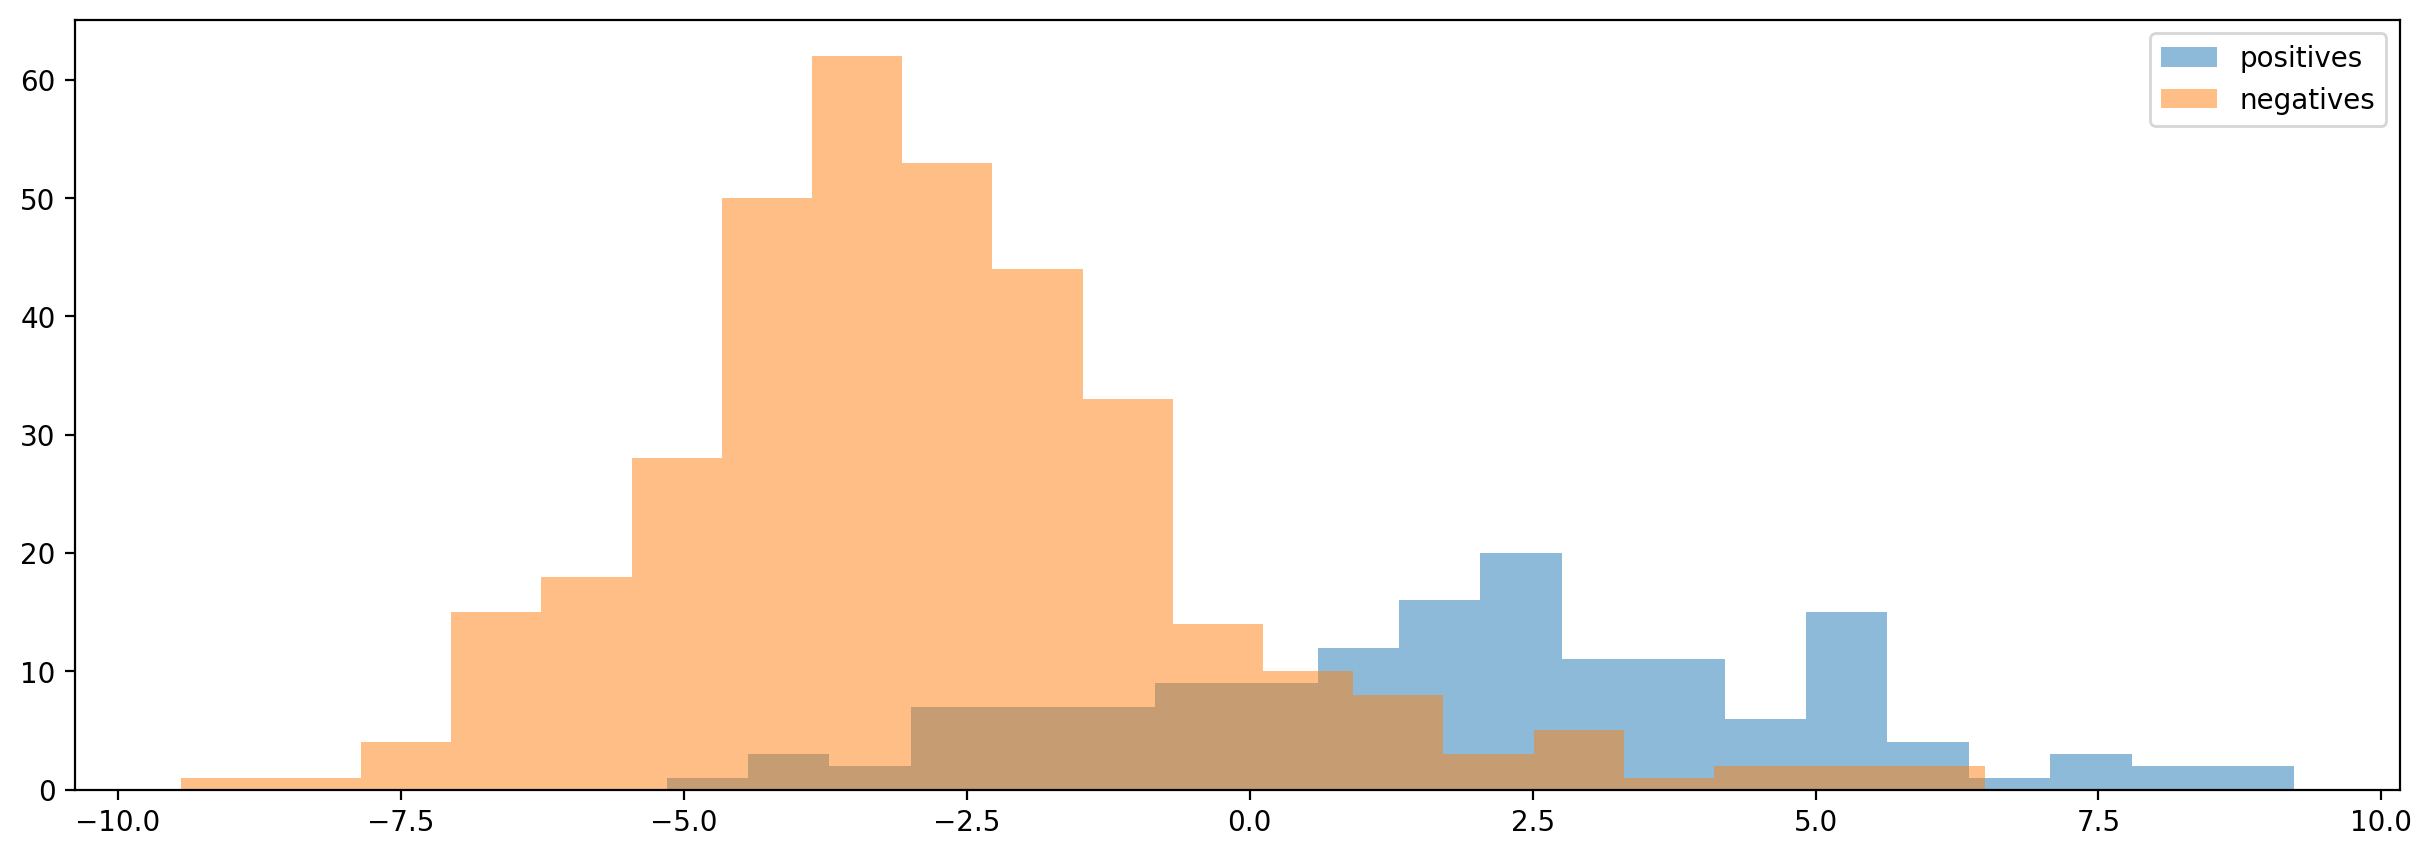

In [50]:
preds = preds.detach().numpy()
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

## Train shallow classifier on Perch embeddings

Training classifiers on Perch works the same way!

Since Perch uses 5 second audio clips as inputs, we'll first re-generate clip labels for 5 second audio segments from the annotated _Rana sierrae_ dataset. 

As before, well just work on the 'A' type call for this example

#### Step 1: Get the Perch model from the Biaocoustics Model Zoo

In [51]:
tag = "birdnet_train" # the branch of the model zoo with compatible models
perch = torch.hub.load(
        f"kitzeslab/bioacoustics-model-zoo:{tag}", 'Perch', trust_repo=True, 
    )

Using cache found in /Users/SML161/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_birdnet_train
/Users/SML161/miniconda3/envs/tensorflow/lib/python3.9/site-packages/opensoundscape/ml/cnn.py:606: UserWarning: 
                    This architecture is not listed in opensoundscape.ml.cnn_architectures.ARCH_DICT.
                    It will not be available for loading after saving the model with .save() (unless using pickle=True). 
                    To make it re-loadable, define a function that generates the architecture from arguments: (n_classes, n_channels) 
                    then use opensoundscape.ml.cnn_architectures.register_architecture() to register the generating function.

                    The function can also set the returned object's .constructor_name to the registered string key in ARCH_DICT
                    to avoid this warning and ensure it is reloaded correctly by opensoundscape.ml.load_model().

                    See opensoundscape.ml.cnn_architectures 

#### Step 2: Generate embeddings on the training and validation data

In [52]:
emb_train = perch.embed(labels_train, return_dfs=False, batch_size=128, num_workers=0)
emb_val = perch.embed(labels_val, return_dfs=False, batch_size=128, num_workers=0)

  0%|          | 0/12 [00:00<?, ?it/s]

2024-10-05 12:07:48.056606: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator jax2tf_infer_fn_/assert_equal_1/Assert/AssertGuard/Assert
2024-10-05 12:12:16.296481: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator jax2tf_infer_fn_/assert_equal_1/Assert/AssertGuard/Assert


  0%|          | 0/4 [00:00<?, ?it/s]

2024-10-05 12:13:48.391838: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator jax2tf_infer_fn_/assert_equal_1/Assert/AssertGuard/Assert


#### Step 3: train the classification head on the desired classes

In [53]:
perch.change_classes(['A']) # replace fc layer with 1-output layer
quick_fit(perch.network, emb_train, labels_train.values, emb_val, labels_val.values,steps=1000)

Epoch 100/1000, Loss: 0.42999351024627686, Val Loss: 0.4536570608615875
val AU ROC: 0.764
val MAP: 0.764
Epoch 200/1000, Loss: 0.3754618763923645, Val Loss: 0.4059055745601654
val AU ROC: 0.784
val MAP: 0.784
Epoch 300/1000, Loss: 0.34698426723480225, Val Loss: 0.38450658321380615
val AU ROC: 0.795
val MAP: 0.795
Epoch 400/1000, Loss: 0.32763686776161194, Val Loss: 0.3716326653957367
val AU ROC: 0.802
val MAP: 0.802
Epoch 500/1000, Loss: 0.3124905228614807, Val Loss: 0.3623782694339752
val AU ROC: 0.811
val MAP: 0.811
Epoch 600/1000, Loss: 0.29978302121162415, Val Loss: 0.35509011149406433
val AU ROC: 0.818
val MAP: 0.818
Epoch 700/1000, Loss: 0.2887539863586426, Val Loss: 0.34911593794822693
val AU ROC: 0.823
val MAP: 0.823
Epoch 800/1000, Loss: 0.27899593114852905, Val Loss: 0.344148725271225
val AU ROC: 0.828
val MAP: 0.828
Epoch 900/1000, Loss: 0.2702459394931793, Val Loss: 0.3400101065635681
val AU ROC: 0.831
val MAP: 0.831
Epoch 1000/1000, Loss: 0.26231375336647034, Val Loss: 0.3

#### Step 4: evaluate

0.9151419678105072

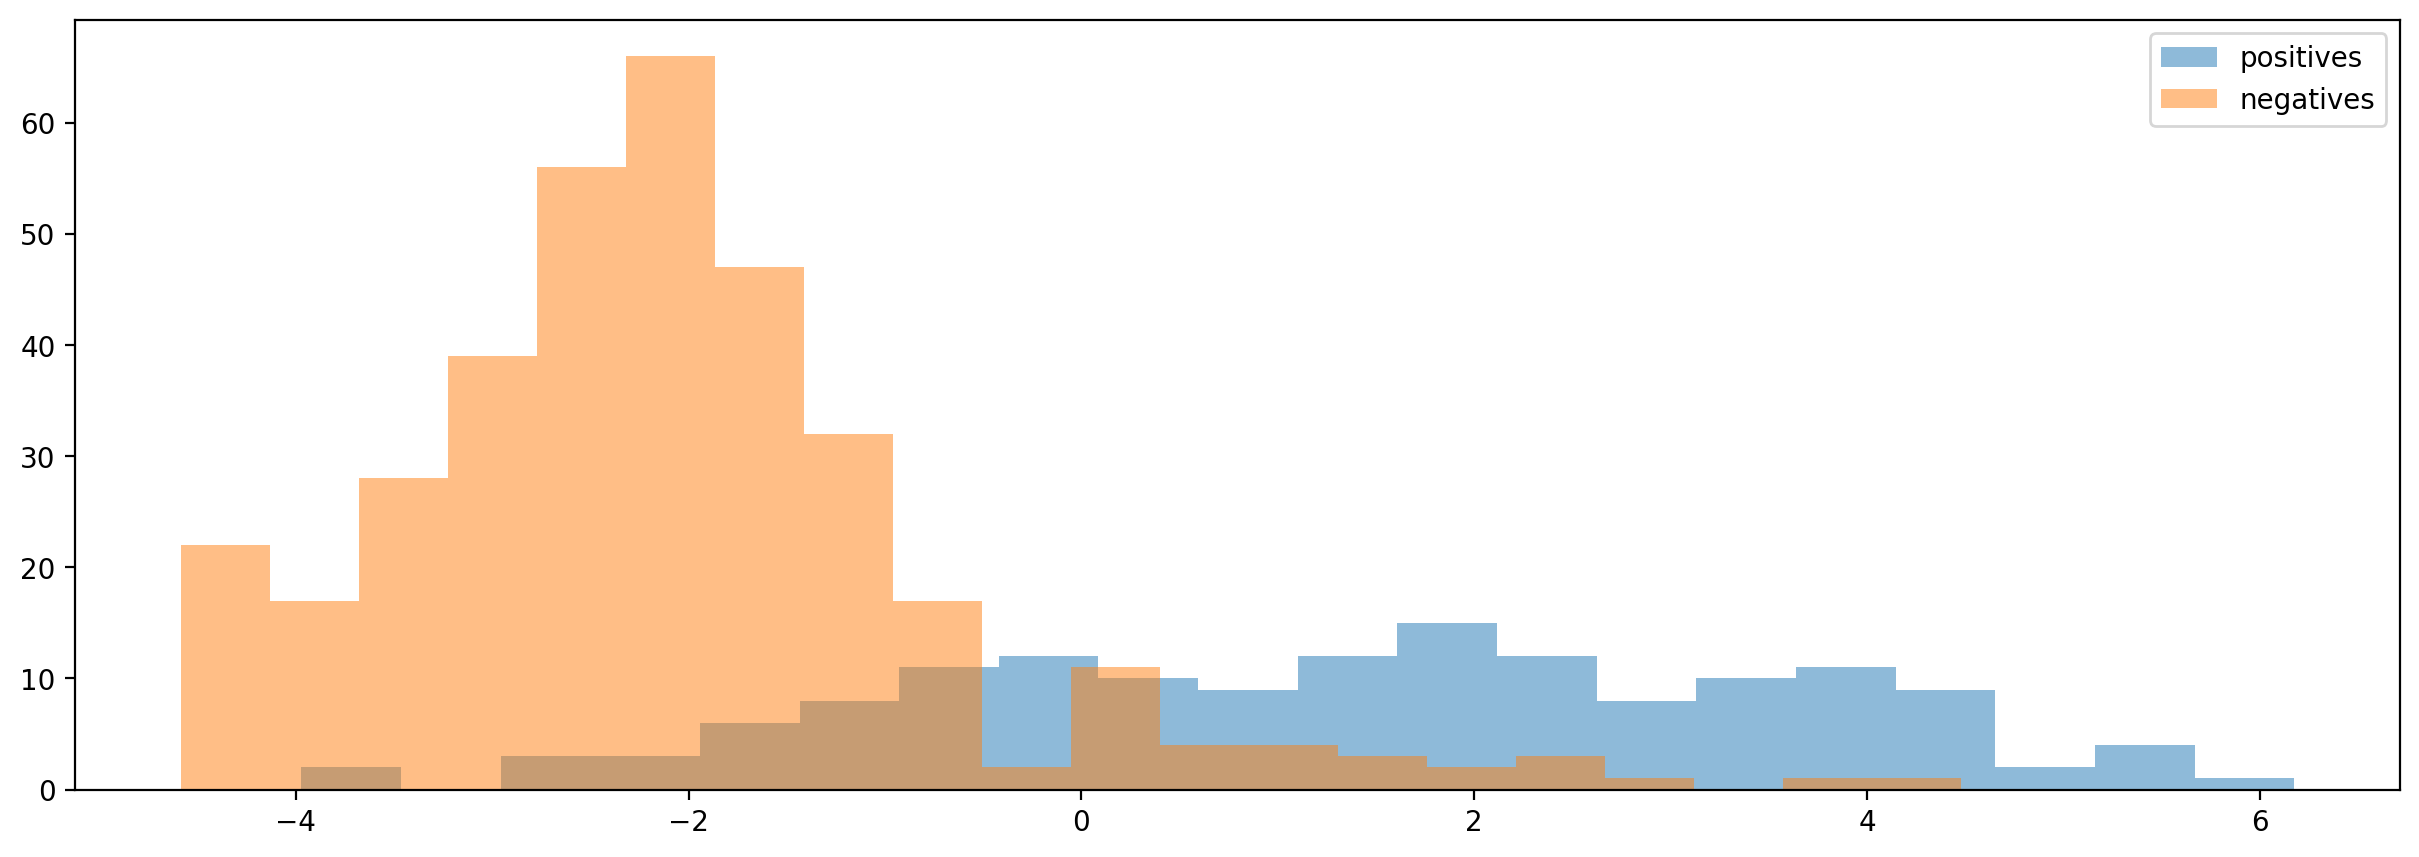

In [57]:
# make predictions by passing the embeddings through the classifier
preds = perch.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score(labels_val.values,preds,average=None)

## Variations on training

The Perch and BirdNET classes from the model zoo implement a .train() function that wraps together the embedding and classifier training shown in this tutorial. So for the least lines of code, you can simply load the model, change classes to your target classes, and run .train():

```python
from opensoundscape.ml import bioacoustics_model_zoo as bmz
from opensoundscape.shallow_classifier import fit_classifier_on_embeddings

# load a model from the model zoo
model = bmz.load('BirdNET')
# or model = bmz.load('Perch')

# define classes for your custom classifier
model.change_classes(train_df.columns)

# fit the trainable PyTorch classifier (`model.network`) on your labels
model.train(train_df,validation_df,num_augmentation_variants=4)

# run inference using your custom classifier
model.predict(validation_df)
```

OpenSoundscape also provides tools to generate embeddings for augmented variations of the input samples (`opensoundscape.shallow_classifier.augmented_embed()`), which could improve the classifiers performance and generalizability. See the transfer learning tutorial for further examples of this and other workflows. 

Here are a few other tools from the `shallow_classifiers` module to check out:

- augmented_embed(): generate embeddings for each sample multiple times, with stochastic augmentation on the audio clips

- fit_classifier_on_embeddings(): this function wraps together the embedding step with the classifier fitting step into a single operation, with support for generating augmented variations of training samples. It returns the embeddings and labels, in case you want to train additional classifiers on them

- MLPClassifier: this class creates a neural network with one or more fully connected layers. This object can be trained by passing it to quick_fit() or fit_classifier_on_embeddings(), or by running the .fit() method (equivalent to quick_fit()). The input size should match the embedding size of the embedding model, and the output size should match the number of classes your model predicts on. 